# Task 1

#### Importing libraries

In [1]:
import os
import json
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
dataset_dir = "/kaggle/input/test-dataset/TestDataSet"
labels_file = os.path.join(dataset_dir, "labels_list.json")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


In [5]:
dataset = datasets.ImageFolder(root=dataset_dir,
                               transform=transform)

In [6]:
with open(labels_file, "r") as f:
    raw = json.load(f)

label_ids = []
for entry in raw:
    idx_str, _ = entry.split(":", 1)
    label_ids.append(int(idx_str))   

assert len(label_ids) == len(dataset.classes), (
    f"found {len(dataset.classes)} folders but {len(label_ids)} labels"
)

In [7]:
wnid_to_idx = {
    wnid: label_ids[i]
    for i, wnid in enumerate(dataset.classes)
}

In [8]:
dataset.class_to_idx = wnid_to_idx

new_samples = []
for img_path, _ in dataset.samples:
    wnid = os.path.basename(os.path.dirname(img_path))
    true_idx = wnid_to_idx[wnid]
    new_samples.append((img_path, true_idx))

dataset.samples = new_samples
dataset.targets = [lbl for _, lbl in new_samples]

### `DataLoader` Configuration

The `DataLoader` is initialized here to manage how data is fed to the model. It orchestrates the loading of samples from our `dataset` object, which serves as the source of all our data.

We've set the `batch_size` to 32, meaning the `DataLoader` will group 32 samples together for each iteration. This batching approach is crucial for computational efficiency, allowing the model to process multiple samples in parallel, and it also helps in obtaining a more stable gradient estimate during training compared to processing individual samples. The value of 32 is a common and often effective starting point, balancing memory usage and training dynamics.

The `shuffle` parameter is set to `False`. This dictates that the order of samples within the dataset will not be randomized at the beginning of each epoch. This setting is typical for validation or testing phases, where consistent evaluation order is preferred. If this loader were intended for training, `shuffle=True` would generally be favored to improve model generalization by preventing it from learning any spurious patterns based on data order.

To accelerate data loading, `num_workers` is configured to 4. This means four separate background processes will be spawned to fetch and prepare data concurrently. By parallelizing data loading, we aim to prevent the CPU from becoming a bottleneck, ensuring that data is ready for the GPU (or main processing unit) as soon as it's needed, leading to faster overall training or evaluation times.

Finally, `pin_memory` is set to `True`. This instructs the `DataLoader` to place the loaded data tensors into CUDA pinned memory on the host (CPU). The primary benefit of using pinned memory is that it enables faster data transfers from the CPU to CUDA-enabled GPUs. This optimization is particularly effective when data transfer speeds are a limiting factor in performance.

In [9]:
loader = DataLoader(dataset,
                    batch_size=32,
                    shuffle=False,
                    num_workers=4,
                    pin_memory=True)

In [10]:
model = models.resnet34(
    weights=models.ResNet34_Weights.IMAGENET1K_V1
).to(device).eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 221MB/s]


### Model Evaluation Loop for Accuracy Calculation

This code block evaluates the trained model's performance on a dataset (presumably a validation or test set provided by `loader`) by calculating its Top-1 and Top-5 accuracy.

First, we initialize counters: `top1_correct` and `top5_correct` to accumulate the number of correctly classified samples for Top-1 and Top-5 predictions respectively, and `total` to keep track of the total number of samples processed.

The entire evaluation process is wrapped in a `torch.no_grad()` context manager. This is crucial because it deactivates PyTorch's autograd engine, meaning gradients will not be computed or stored. For inference or evaluation, gradient calculation is unnecessary and would consume extra memory and computation time.

We then iterate through the `loader`, which yields batches of `images` and their corresponding ground truth labels, `trues`.
Inside the loop:
1.  Both `images` and `trues` are moved to the specified `device` (e.g., GPU or CPU) where the model computations will occur. This ensures data and model are on the same device, preventing runtime errors and leveraging hardware acceleration if available.
2.  The `model` processes the input `images` to produce `outputs`. These `outputs` are typically raw scores (logits) for each class.
3.  `outputs.topk(5, dim=1)` is used to find the indices of the top 5 highest scores for each image in the batch. The `dim=1` argument specifies that the top-k operation should be performed along the class dimension. This returns two tensors: the top-k values (which we ignore here with `_`) and their corresponding indices, `preds5`. `preds5` will have a shape of `(batch_size, 5)`.
4.  To check for correct predictions, `preds5.eq(trues.view(-1,1))` compares each of the top 5 predicted class indices with the true label. `trues.view(-1,1)` reshapes the true labels tensor to `(batch_size, 1)` to enable broadcasting with `preds5` `(batch_size, 5)`, resulting in a boolean tensor `hits` of shape `(batch_size, 5)`. An element `hits[i, j]` is `True` if the j-th top prediction for the i-th sample matches the true label.
5.  For Top-1 accuracy, `hits[:, :1].sum().item()` counts how many samples were correctly classified as the very top prediction. `hits[:, :1]` selects the first column of `hits` (corresponding to the top-1 prediction), `sum()` counts the `True` values (correct predictions), and `.item()` converts the single-element tensor to a Python number. This count is added to `top1_correct`.
6.  For Top-5 accuracy, `hits.any(dim=1).sum().item()` checks if the true label is present anywhere within the top 5 predictions for each sample. `hits.any(dim=1)` returns a boolean tensor indicating `True` for each sample where at least one of its top 5 predictions was correct. `sum().item()` then counts these correctly classified samples and adds them to `top5_correct`.
7.  `total` is incremented by `trues.size(0)`, which is the number of samples in the current batch.

After iterating through all batches in the `loader`, the final Top-1 and Top-5 accuracies are calculated. `top1` is `top1_correct / total * 100`, and `top5` is `top5_correct / total * 100`, converting the counts into percentages.

Finally, the total number of evaluated images and the calculated Top-1 and Top-5 accuracies are printed to the console, formatted to two decimal places.

In [11]:
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, trues in loader:
        images = images.to(device)
        trues = trues.to(device)
        outputs = model(images)               
        _, preds5 = outputs.topk(5, dim=1)    

        hits = preds5.eq(trues.view(-1,1))
        top1_correct += hits[:, :1].sum().item()
        top5_correct += hits.any(dim=1).sum().item()
        total += trues.size(0)

top1 = top1_correct / total * 100
top5 = top5_correct / total * 100

print(f"Evaluated {total} images")
print(f"  Top-1 accuracy: {top1:.2f}%")
print(f"  Top-5 accuracy: {top5:.2f}%")

Evaluated 500 images
  Top-1 accuracy: 76.00%
  Top-5 accuracy: 94.20%


### Detailed Prediction Logging to JSON

This script segment is designed to perform inference on a dataset using the trained `model`, and then log detailed results for each individual sample into a JSON file. This is useful for fine-grained error analysis or for submission to challenges.

We begin by importing the necessary libraries: `json` for handling JSON file operations and `torch` for PyTorch functionalities.
An empty list `results` is initialized to store the prediction details for each image, and an `idx` counter is set to 0. This `idx` will be used to track the current image's index in the original `dataset` to retrieve its file path.

Before starting the inference loop, `model.eval()` is called. This sets the model to evaluation mode.
*   **Why**: This is important because certain layers, like Dropout and BatchNorm, behave differently during training and evaluation. `model.eval()` ensures they use their inference-time behavior.

The inference loop is wrapped within a `with torch.no_grad():` block.
*   **Why**: This context manager disables gradient calculations, which are not needed for inference. Doing so reduces memory consumption and speeds up computations.

Inside the loop, we iterate through the `loader`, which provides batches of `images` and their ground truth labels `trues`.
1.  `images = images.to(device)`: The input images are moved to the specified `device` (e.g., GPU) for model processing.
2.  `preds = model(images).argmax(dim=1).cpu().tolist()`:
    *   `model(images)`: The model performs a forward pass on the images, producing raw output scores (logits) for each class.
    *   `.argmax(dim=1)`: For each image in the batch, this finds the index of the class with the highest score. This index represents the model's predicted class. `dim=1` ensures this operation is performed across the class dimension.
    *   `.cpu()`: The resulting tensor of predicted indices is moved from the `device` (potentially GPU) back to the CPU.
        *   **Why**: This is necessary because subsequent operations like `.tolist()` and interaction with the `dataset.samples` (which is typically CPU-based) require the data to be on the CPU.
    *   `.tolist()`: The tensor of predicted indices is converted into a Python list.

Next, we iterate through the true labels and predicted labels for each image in the current batch using `zip(trues.tolist(), preds)`. `trues.tolist()` converts the ground truth tensor to a Python list.
For each `true` label and `pred`icted label:
1.  `img_path = dataset.samples[idx][0]`: The file path of the current image is retrieved from the `dataset.samples` attribute. It's assumed that `dataset.samples` is a list of tuples, where the first element `[0]` of each tuple is the image path. The `idx` counter ensures we fetch the path for the correct image.
2.  A dictionary containing `image_path`, `true_idx` (the ground truth class index), `pred_idx` (the model's predicted class index), and a boolean `correct` flag (True if `pred == true`, False otherwise) is created.
3.  This dictionary is appended to the `results` list.
4.  `idx += 1`: The global image index `idx` is incremented to point to the next image in the dataset.

After processing all batches from the `loader`, the script opens a file named `task1_results.json` in write mode (`"w"`).
*   `json.dump(results, f, indent=2)`: The entire `results` list (which now contains dictionaries for every image) is serialized into JSON format and written to the file `f`. The `indent=2` argument formats the JSON output with an indentation of 2 spaces, making it more human-readable.

Finally, a confirmation message `f"Saved {len(results)} entries to task1_results.json"` is printed to the console, indicating how many image predictions were successfully saved.

In [12]:
import json, torch

results = []
idx = 0

model.eval()
with torch.no_grad():
    for images, trues in loader:
        images = images.to(device)
        preds = model(images).argmax(dim=1).cpu().tolist()
        for true, pred in zip(trues.tolist(), preds):
            img_path = dataset.samples[idx][0]
            results.append({
                "image_path": img_path,
                "true_idx":   true,
                "pred_idx":   pred,
                "correct":    (pred == true)
            })
            idx += 1

with open("task1_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved {len(results)} entries to task1_results.json")


Saved 500 entries to task1_results.json


# Task 2

In [13]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [14]:
dataset_dir = "/kaggle/input/test-dataset/TestDataSet"  
labels_file = os.path.join(dataset_dir, "labels_list.json")
output_dir  = "/kaggle/working/Adversarial_Test_Set_1"
os.makedirs(output_dir, exist_ok=True)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)


In [17]:
with open(labels_file, "r") as f:
    raw = json.load(f)
label_ids = [int(entry.split(":",1)[0]) for entry in raw]
assert len(label_ids)==len(dataset.classes)

wnid_to_idx = { wnid: label_ids[i] 
                for i, wnid in enumerate(dataset.classes) }
dataset.class_to_idx = wnid_to_idx

new_samples = []
for path, _ in dataset.samples:
    wnid = os.path.basename(os.path.dirname(path))
    new_samples.append((path, wnid_to_idx[wnid]))
dataset.samples = new_samples
dataset.targets = [t for _,t in new_samples]

loader = DataLoader(dataset, batch_size=32, shuffle=False,
                    num_workers=4, pin_memory=True)


In [18]:
model = models.resnet34(
    weights=models.ResNet34_Weights.IMAGENET1K_V1
).to(device).eval()
loss_fn = nn.CrossEntropyLoss()

In [19]:
epsilon = 0.02
mean = torch.tensor([0.485,0.456,0.406]).view(1,3,1,1).to(device)
std  = torch.tensor([0.229,0.224,0.225]).view(1,3,1,1).to(device)

### Adversarial Attack Generation (FGSM) and Robustness Evaluation

This section of the code implements a common type of adversarial attack, likely a variation of the Fast Gradient Sign Method (FGSM), to generate perturbed images. It then evaluates the model's robustness by measuring its Top-1 and Top-5 accuracy on these adversarially crafted examples and saves the generated adversarial images.

First, we set up key parameters and storage:
*   `epsilon = 0.02`: This defines the magnitude of the perturbation. A smaller epsilon results in less perceptible changes to the image but might be less effective in fooling the model.
*   `top1_corr`, `top5_corr`, `total`: Counters for calculating Top-1 and Top-5 accuracy on the adversarial examples.
*   `adv_examples`: A list to store a few examples of original images, their adversarial counterparts, and the difference, specifically for cases where the attack was successful in misclassifying the image.

The core logic resides in a loop iterating through the `loader`, which provides batches of normalized images (`imgs_norm`) and their true labels (`trues`). `batch_idx` keeps track of the current batch number.

**Inside each batch iteration:**

1.  **Data Preparation & Gradient Setup**:
    *   `imgs_norm = imgs_norm.to(device)` and `trues = trues.to(device)`: Data is moved to the target computation `device`.
    *   `imgs_pixel = imgs_norm * std + mean`: The normalized input images are denormalized back to their original pixel value range (typically [0, 1]). This step is crucial because we want to apply the perturbation in the pixel space to ensure the changes are meaningful visually and adhere to image constraints. `std` and `mean` are assumed to be predefined tensors for denormalization.
    *   `imgs_pixel = imgs_pixel.clone().detach().requires_grad_(True)`:
        *   `.clone().detach()`: Creates a new tensor that doesn't share memory with `imgs_norm` and is detached from the computation graph.
        *   `.requires_grad_(True)`: This is essential. It tells PyTorch to track operations on `imgs_pixel` so that we can compute gradients with respect to these input pixel values. This is the foundation for gradient-based adversarial attacks.
    *   `imgs_norm2 = (imgs_pixel - mean) / std`: The pixel-space images (now tracking gradients) are re-normalized. This is because the `model` expects normalized inputs for its forward pass.

2.  **Adversarial Perturbation Generation**:
    *   `outputs = model(imgs_norm2)`: A forward pass is performed using the (re-normalized) clean images to get the model's predictions.
    *   `loss = loss_fn(outputs, trues)`: The loss (e.g., cross-entropy) between the model's predictions and the true labels is calculated. The attack aims to maximize this loss for the correct class or minimize it for a target incorrect class.
    *   `model.zero_grad()`: Clears any pre-existing gradients in the model parameters. While we are interested in gradients w.r.t. input, it's good practice.
    *   `loss.backward()`: Computes the gradients of the `loss` with respect to all tensors that have `requires_grad=True`, importantly including our `imgs_pixel`.
    *   `grad_norm = imgs_pixel.grad.data / std`: Retrieves the gradient of the loss with respect to `imgs_pixel`. This gradient indicates the direction in pixel space that would most increase the loss. It's then divided by `std`; this step effectively scales the gradient from the pixel domain to the normalized domain if the attack aims to compute the sign in the normalized space, or it's a step towards understanding the gradient's effect on the normalized input if `epsilon` is meant to be applied in a normalized sense. *The exact interpretation depends on whether `epsilon` is intended for pixel space or normalized space.*
    *   `adv_pixel = torch.clamp(imgs_pixel + epsilon * grad_norm.sign(), 0.0, 1.0)`: This is the core FGSM-like step.
        *   `grad_norm.sign()`: Takes the sign of the gradient. This determines the direction of perturbation for each pixel (+1 or -1).
        *   `epsilon * grad_norm.sign()`: Scales this direction by `epsilon` to control the perturbation magnitude.
        *   `imgs_pixel + ...`: Adds the perturbation to the original clean image in pixel space.
        *   `torch.clamp(..., 0.0, 1.0)`: Ensures the resulting adversarial image `adv_pixel` has pixel values within the valid range (e.g., [0, 1]), preventing unrealistic pixel values.
    *   `adv_norm = (adv_pixel - mean) / std`: The generated adversarial image in pixel space is re-normalized to be fed into the model.

3.  **Evaluation on Adversarial Examples**:
    *   `with torch.no_grad(): out_adv = model(adv_norm)`: The model makes predictions on the newly crafted adversarial images (`adv_norm`). `torch.no_grad()` is used as we are only evaluating and don't need gradient computation here.
    *   `_, preds5 = out_adv.topk(5, dim=1)`: Gets the top 5 predicted class indices for the adversarial images.
    *   The subsequent lines (`hits = preds5.eq(...)`, `top1_corr += ...`, `top5_corr += ...`, `total += ...`) are identical to standard evaluation, but now they measure the model's accuracy on the *adversarial* inputs.

4.  **Saving Adversarial Images and Logging Failures**:
    *   A loop iterates through each image in the current batch (`for i in range(trues.size(0))`).
    *   `rel_path = os.path.relpath(...)`: Constructs a relative path for the current image, likely to maintain the original dataset's directory structure within the `output_dir`.
    *   `save_path = os.path.join(output_dir, rel_path)`: Defines the full path where the adversarial image will be saved.
    *   `os.makedirs(os.path.dirname(save_path), exist_ok=True)`: Creates the necessary directory structure for saving the image if it doesn't already exist.
    *   `img_np = (adv_pixel[i].detach().cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)`:
        *   `adv_pixel[i]`: Selects the i-th adversarial image from the batch.
        *   `.detach().cpu()`: Detaches from the computation graph and moves to CPU.
        *   `.permute(1,2,0)`: Changes tensor dimensions from (C, H, W) typical for PyTorch to (H, W, C) typical for image libraries like PIL/OpenCV and Matplotlib.
        *   `.numpy()`: Converts to a NumPy array.
        *   `* 255).astype(np.uint8)`: Scales pixel values from [0, 1] to [0, 255] and converts to an 8-bit unsigned integer type, standard for image files.
    *   `Image.fromarray(img_np).save(save_path)`: Saves the adversarial image using the PIL (Pillow) library.
    *   The `if len(adv_examples) < 5 and preds5[i,0] != trues[i]:` block records up to 5 examples where the attack successfully fooled the model (i.e., the top-1 prediction on the adversarial image is incorrect).
        *   It stores the original image (`orig_np`), the adversarial image (`adv_np`), and a normalized difference image (`diff`) for later inspection. These are also converted to NumPy arrays in the (H, W, C) format and clipped to the [0,1] range for consistent visualization. The difference is normalized by its maximum value to highlight the areas of most significant change.

After processing all batches, `top1_corr`, `top5_corr`, and `total` can be used to calculate the model's robustness (accuracy on adversarial examples). The `adv_examples` list will contain a few illustrative samples of successful attacks.

In [20]:
top1_corr = 0
top5_corr = 0
total      = 0
adv_examples = []

for batch_idx, (imgs_norm, trues) in enumerate(loader):
    imgs_norm = imgs_norm.to(device)
    trues     = trues.to(device)
    imgs_pixel = imgs_norm * std + mean
    imgs_pixel = imgs_pixel.clone().detach().requires_grad_(True)
    imgs_norm2 = (imgs_pixel - mean) / std

    outputs = model(imgs_norm2)
    loss    = loss_fn(outputs, trues)
    model.zero_grad()
    loss.backward()
    grad_norm  = imgs_pixel.grad.data / std
    adv_pixel  = torch.clamp(imgs_pixel + epsilon * grad_norm.sign(), 0.0, 1.0)
    adv_norm   = (adv_pixel - mean) / std

    with torch.no_grad():
        out_adv = model(adv_norm)
    _, preds5 = out_adv.topk(5, dim=1)

    hits = preds5.eq(trues.view(-1,1))
    top1_corr += hits[:, :1].sum().item()
    top5_corr += hits.any(dim=1).sum().item()
    total     += trues.size(0)

    for i in range(trues.size(0)):
        rel_path = os.path.relpath(dataset.samples[batch_idx*loader.batch_size + i][0],
                                   dataset_dir)
        save_path = os.path.join(output_dir, rel_path)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # detach before numpy()
        img_np = (adv_pixel[i].detach().cpu().permute(1,2,0).numpy() * 255
                 ).astype(np.uint8)
        Image.fromarray(img_np).save(save_path)

        # record up to 5 failures
        if len(adv_examples) < 5 and preds5[i,0] != trues[i]:
            orig_np = np.clip(imgs_pixel[i].detach().cpu().permute(1,2,0).numpy(), 0,1)
            adv_np  = np.clip(adv_pixel[i].detach().cpu().permute(1,2,0).numpy(),  0,1)
            diff    = np.abs(adv_np - orig_np)
            diff    = diff / diff.max()
            adv_examples.append((orig_np, adv_np, diff))

In [21]:
# ── RESULTS ──
# use the clean accuracies you measured earlier
clean_top1 = 76
clean_top5 = 94.20

# adversarial accuracies computed above
adv_top1 = top1_corr / total * 100
adv_top5 = top5_corr / total * 100

print("Clean examples:")
print(f"  Top-1 accuracy: {clean_top1:.2f}%")
print(f"  Top-5 accuracy: {clean_top5:.2f}%\n")

print(f"Adversarial examples (ε={epsilon}):")
print(f"  Top-1 accuracy: {adv_top1:.2f}%")
print(f"  Top-5 accuracy: {adv_top5:.2f}%\n")
drop1=clean_top1 - adv_top1
drop5=clean_top5 - adv_top5
print("Accuracy drops:")
print(f"  Top-1 drop: {clean_top1 - adv_top1:.2f}%")
print(f"  Top-5 drop: {clean_top5 - adv_top5:.2f}%")


Clean examples:
  Top-1 accuracy: 76.00%
  Top-5 accuracy: 94.20%

Adversarial examples (ε=0.02):
  Top-1 accuracy: 3.00%
  Top-5 accuracy: 19.00%

Accuracy drops:
  Top-1 drop: 73.00%
  Top-5 drop: 75.20%


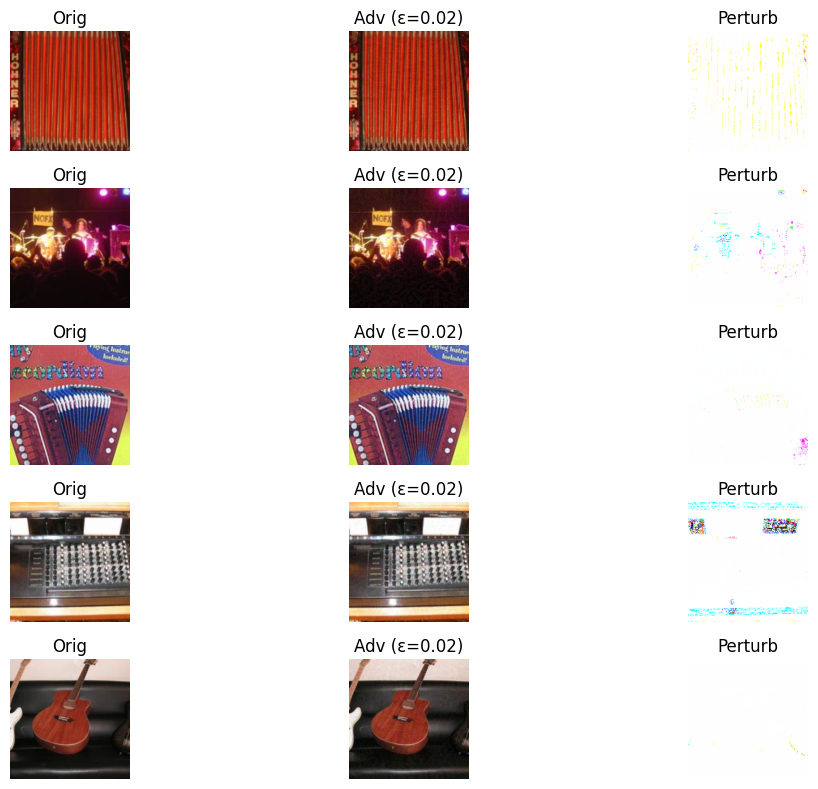

In [22]:
# ── VISUALIZE 5 FAILURES ──
plt.figure(figsize=(12, 8))
for i, (o, a, d) in enumerate(adv_examples):
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(o); plt.title("Orig"); plt.axis('off')
    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(a); plt.title("Adv (ε=0.02)"); plt.axis('off')
    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(d); plt.title("Perturb"); plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
metrics = {
    "task2": {
        "epsilon": epsilon,
        "clean_top1_baseline": 76.0,
        "clean_top5_baseline": 94.2,
        "adv_top1": adv_top1,
        "adv_top5": adv_top5,
        "drop_top1": drop1,
        "drop_top5": drop5
    }
}
with open(os.path.join(output_dir, "task2_results.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Task 3

In [24]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [25]:
epsilon    = 0.02          
steps      = 10            
alpha      = epsilon / steps
output_dir2 = "/kaggle/working/Adversarial_Test_Set_2"
os.makedirs(output_dir2, exist_ok=True)

In [26]:
top1_pgd = 0
top5_pgd = 0
total    = 0
pgd_examples = []

### Adversarial Attack Generation (PGD) and Robustness Evaluation

This code segment implements the Projected Gradient Descent (PGD) attack, a more powerful iterative adversarial attack method, to craft adversarial examples. It then evaluates the model's robustness against these PGD attacks and saves the generated adversarial images along with some failure examples.

The main logic is within a loop that iterates over batches from the `loader`.

**For each batch:**

1.  **Data Preparation**:
    *   `imgs_norm`, `trues` are moved to the `device`.
    *   `imgs_pixel = imgs_norm * std + mean`: Original images are denormalized to pixel space (typically [0, 1]). This is the space where perturbations are constrained.

2.  **Initialization of Adversarial Candidate**:
    *   `delta = torch.empty_like(imgs_pixel).uniform_(-epsilon, epsilon)`: A random perturbation `delta` is created with the same shape as `imgs_pixel`. Each element of `delta` is sampled uniformly from `[-epsilon, epsilon]`.
        *   **Why**: PGD often starts with a random perturbation within the allowed `epsilon`-ball around the original image. This helps in escaping poor local optima during the optimization process and finding stronger adversarial examples.
    *   `adv_pix = torch.clamp(imgs_pixel + delta, 0.0, 1.0).detach().requires_grad_(True)`:
        *   The initial random perturbation `delta` is added to the clean `imgs_pixel`.
        *   `torch.clamp(..., 0.0, 1.0)`: Ensures the initial adversarial candidate `adv_pix` stays within valid pixel bounds.
        *   `.detach().requires_grad_(True)`: The resulting `adv_pix` is detached from any previous computation graph (though `delta` was new, this is good practice) and then its `requires_grad` flag is set to `True`. This allows us to compute gradients with respect to this adversarial candidate in the PGD iterations.

3.  **Iterative PGD Attack Loop (`for _ in range(steps):`)**:
    This loop iteratively refines the adversarial perturbation.
    *   `adv_norm = (adv_pix - mean) / std`: The current adversarial candidate `adv_pix` (in pixel space) is normalized to be fed into the model.
    *   `outputs = model(adv_norm)`: The model performs a forward pass on the current `adv_norm`.
    *   `loss = nn.CrossEntropyLoss()(outputs, trues)`: The loss (typically Cross-Entropy) is calculated between the model's predictions on the adversarial candidate and the true labels. The goal is to maximize this loss.
    *   `model.zero_grad()`: Clears gradients from previous iterations for model parameters (less critical here as we primarily care about input gradients, but good practice).
    *   `loss.backward()`: Computes the gradients of the `loss` with respect to all tensors with `requires_grad=True`, most importantly `adv_pix`.
    *   `grad = adv_pix.grad.data`: Retrieves the gradient of the loss with respect to the current adversarial candidate `adv_pix`.
    *   `adv_pix = adv_pix + alpha * grad.sign()`: This is the gradient ascent step. The adversarial image is updated by moving it slightly in the direction of the sign of the gradient, scaled by the step size `alpha`. This step aims to increase the loss.
    *   **Projection Step 1 (L-infinity ball projection)**:
        `adv_pix = torch.max(torch.min(adv_pix, imgs_pixel + epsilon), imgs_pixel - epsilon)`
        *   **Why**: This projects the updated `adv_pix` back into the `epsilon`-ball around the original clean image `imgs_pixel`.
        *   `imgs_pixel + epsilon` and `imgs_pixel - epsilon` define the upper and lower bounds of the allowed perturbation for each pixel.
        *   `torch.min(adv_pix, imgs_pixel + epsilon)` ensures `adv_pix` doesn't exceed the upper bound.
        *   `torch.max(..., imgs_pixel - epsilon)` ensures the result doesn't go below the lower bound.
    *   **Projection Step 2 (Valid pixel range projection)**:
        `adv_pix = torch.clamp(adv_pix, 0.0, 1.0).detach().requires_grad_(True)`
        *   `torch.clamp(adv_pix, 0.0, 1.0)`: Ensures the pixel values of `adv_pix` remain valid (e.g., between 0 and 1).
        *   `.detach().requires_grad_(True)`: The updated `adv_pix` is detached from the current computation graph (to prevent building an overly long graph across PGD steps) and then `requires_grad` is set to `True` again for the next iteration of the PGD loop.

4.  **Evaluation on Final Adversarial Examples**:
    *   After `steps` iterations, `adv_norm = (adv_pix - mean) / std` normalizes the final crafted adversarial image.
    *   `with torch.no_grad(): out_adv = model(adv_norm)`: The model evaluates these final adversarial images without gradient tracking.
    *   `_, preds5 = out_adv.topk(5, dim=1)`: Gets the top 5 predictions.
    *   The subsequent lines (`hits = ...`, `top1_pgd += ...`, `top5_pgd += ...`, `total += ...`) calculate and accumulate the Top-1 and Top-5 accuracies on these PGD adversarial examples.

5.  **Saving Adversarial Images and Logging Failures**:
    *   This part is very similar to the previous FGSM example. For each image in the batch:
        *   Its original path is retrieved, and a corresponding save path in `output_dir2` is constructed. Directories are created if needed.
        *   `img_uint8 = (adv_pix[i].detach().cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)`: The final PGD adversarial image `adv_pix[i]` is converted to a NumPy array, permuted to (H, W, C), scaled to [0, 255], and cast to `uint8`.
        *   `Image.fromarray(img_uint8).save(save_path)`: The image is saved.
        *   `if len(pgd_examples) < 5 and preds5[i,0] != trues[i]:`: If the attack was successful (top-1 prediction is wrong) and we haven't stored 5 examples yet, the original image, the adversarial image, and their normalized difference are stored in `pgd_examples` for later analysis. A small epsilon `1e-8` is added to the denominator during diff normalization to prevent division by zero if the difference is all zeros.

This comprehensive PGD attack loop allows for a robust evaluation of the model's resilience to iterative, constrained adversarial perturbations.

In [27]:
for batch_idx, (imgs_norm, trues) in enumerate(loader):
    imgs_norm = imgs_norm.to(device)
    trues     = trues.to(device)

    imgs_pixel = imgs_norm * std + mean

    delta   = torch.empty_like(imgs_pixel).uniform_(-epsilon, epsilon)
    adv_pix = torch.clamp(imgs_pixel + delta, 0.0, 1.0).detach().requires_grad_(True)

    for _ in range(steps):
        adv_norm = (adv_pix - mean) / std
        outputs  = model(adv_norm)
        loss     = nn.CrossEntropyLoss()(outputs, trues)
        model.zero_grad()
        loss.backward()

        grad     = adv_pix.grad.data
        adv_pix  = adv_pix + alpha * grad.sign()

        adv_pix  = torch.max(torch.min(adv_pix, imgs_pixel + epsilon),
                             imgs_pixel - epsilon)
        adv_pix  = torch.clamp(adv_pix, 0.0, 1.0).detach().requires_grad_(True)

    adv_norm = (adv_pix - mean) / std
    with torch.no_grad():
        out_adv = model(adv_norm)
    _, preds5 = out_adv.topk(5, dim=1)

    hits     = preds5.eq(trues.view(-1,1))
    top1_pgd += hits[:, :1].sum().item()
    top5_pgd += hits.any(dim=1).sum().item()
    total    += trues.size(0)

    for i in range(trues.size(0)):
        orig_path = dataset.samples[batch_idx * loader.batch_size + i][0]
        rel_path  = os.path.relpath(orig_path, dataset_dir)
        save_path = os.path.join(output_dir2, rel_path)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        img_uint8 = (adv_pix[i].detach().cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
        Image.fromarray(img_uint8).save(save_path)

        if len(pgd_examples) < 5 and preds5[i,0] != trues[i]:
            orig_np = imgs_pixel[i].detach().cpu().permute(1,2,0).numpy()
            adv_np  = adv_pix[i].detach().cpu().permute(1,2,0).numpy()
            diff    = np.abs(adv_np - orig_np)
            diff    = diff / (diff.max() + 1e-8)
            pgd_examples.append((orig_np, adv_np, diff))

In [28]:
clean_top1 = 76.00
clean_top5 = 94.20
adv_top1   = top1_pgd / total * 100
adv_top5   = top5_pgd / total * 100
drop1      = clean_top1 - adv_top1
drop5      = clean_top5 - adv_top5

print("Clean examples:")
print(f"  Top-1 accuracy: {clean_top1:.2f}%")
print(f"  Top-5 accuracy: {clean_top5:.2f}%\n")

print(f"Adversarial examples (PGD-10, ε={epsilon}):")
print(f"  Top-1 accuracy: {adv_top1:.2f}%")
print(f"  Top-5 accuracy: {adv_top5:.2f}%\n")

print("Accuracy drops:")
print(f"  Top-1 drop: {drop1:.2f}%")
print(f"  Top-5 drop: {drop5:.2f}%")

Clean examples:
  Top-1 accuracy: 76.00%
  Top-5 accuracy: 94.20%

Adversarial examples (PGD-10, ε=0.02):
  Top-1 accuracy: 0.00%
  Top-5 accuracy: 1.80%

Accuracy drops:
  Top-1 drop: 76.00%
  Top-5 drop: 92.40%


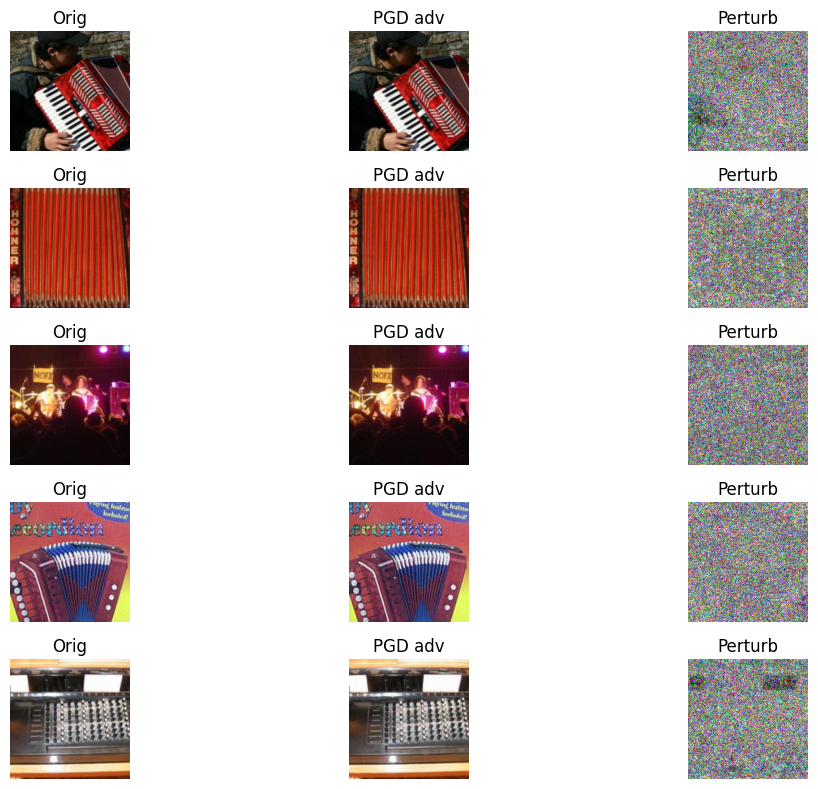

In [29]:
# visualize 5 failure cases
plt.figure(figsize=(12, 8))
for i, (o, a, d) in enumerate(pgd_examples):
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(o); plt.title("Orig"); plt.axis('off')
    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(a); plt.title("PGD adv"); plt.axis('off')
    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(d); plt.title("Perturb"); plt.axis('off')
plt.tight_layout()
plt.show()

In [30]:
metrics = {
    "task3": {
        "epsilon": epsilon,
        "steps": steps,
        "alpha": alpha,
        "clean_top1": clean_top1,
        "clean_top5": clean_top5,
        "adv_top1": adv_top1,
        "adv_top5": adv_top5,
        "drop_top1": drop1,
        "drop_top5": drop5
    }
}
with open(os.path.join(output_dir2, "task3_results.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Task 4

In [31]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [32]:
# PARAMETERS
patch_size     = 32
epsilon_patch  = 0.75
steps          = 100
alpha_patch    = epsilon_patch / steps
restarts       = 3            
output_dir3    = "/kaggle/working/Adversarial_Test_Set_3"
os.makedirs(output_dir3, exist_ok=True)

In [33]:
# METRICS & STORAGE
top1_patch = 0
top5_patch = 0
total      = 0
patch_examples = []

clean_top1 = 76.00
clean_top5 = 94.20
loss_fn    = nn.CrossEntropyLoss()

kernel = torch.ones(1, 1, patch_size, patch_size).to(device)

### Targeted Adversarial Patch Attack with Multiple Restarts

This code implements a sophisticated targeted adversarial attack that aims to misclassify an image into a specific target class by modifying only a small, contiguous "patch" region of the image. It uses multiple restarts and an iterative optimization process (similar to PGD) to find an effective patch.

Key parameters (assumed to be defined elsewhere):
*   `epsilon_patch`: Maximum L-infinity perturbation allowed for each pixel within the patch, relative to the original pixel values in that patch.
*   `alpha_patch`: Step size for updating pixel values within the patch during optimization.
*   `steps`: Number of iterative steps to refine the adversarial patch in each restart.
*   `restarts`: Number of times the attack process is re-initialized (typically with a fresh start or random initialization) to improve the chances of finding a strong adversarial example.
*   `patch_size` (or `ps` implicitly used in `kernel` and coordinate calculations): The side length of the square patch.
*   `kernel`: A convolution kernel, likely a tensor of ones with shape `(1, 1, patch_size, patch_size)`, used to sum gradient magnitudes over patch-sized regions for localization.
*   `loss_fn`: The loss function, e.g., `nn.CrossEntropyLoss`.
*   `mean`, `std`: Normalization constants.
*   `output_dir3`: Directory to save generated adversarial patch images.
*   `top1_patch`, `top5_patch`, `total`, `patch_examples`: Variables for metrics and storing examples.

**Looping through data batches:**

1.  **Data Preparation & Target Selection**:
    *   `imgs_norm`, `trues` are loaded and moved to `device`.
    *   `imgs_pixel = imgs_norm * std + mean`: Images are denormalized to pixel space [0,1]. `B,_,H,W` captures batch size and image dimensions.
    *   **Targeted Attack Setup**:
        *   `with torch.no_grad(): logits_clean = model(imgs_norm)`: Get predictions on the clean image.
        *   `probs = F.softmax(logits_clean, dim=1)`: Convert logits to probabilities.
        *   `targets_tgt = torch.argmin(probs, dim=1)`: The target class `targets_tgt` for each image is chosen as the class with the *lowest* initial probability. This is a common strategy for targeted attacks when a specific arbitrary target isn't given, as it's often easier to push the image towards a class it least resembles.
    *   `best_adv = torch.zeros_like(imgs_pixel)`: Initializes a tensor to store the most effective adversarial image found so far for each sample in the batch (across all restarts).
    *   `lowest_true_p = torch.ones(B, device=device) * 1e9`: Tracks the lowest probability achieved for the *true class* for each sample. The goal is to minimize this.

2.  **Multiple Restarts Loop (`for r in range(restarts):`)**:
    *   **Why Restarts?**: The optimization landscape for adversarial attacks can have many local optima. Restarts help explore different starting points or initializations, increasing the chance of finding a more potent adversarial perturbation.
    *   `adv_pix = imgs_pixel.clone().detach()`: For each restart, the adversarial candidate `adv_pix` starts from a copy of the clean image. (Some PGD variants might add random noise here, but this starts clean for the patch attack logic).

3.  **Iterative Patch Optimization Loop (`for _ in range(steps):`)**:
    This loop refines the adversarial patch.
    *   `adv_pix.requires_grad_(True)`: Enable gradient computation for the current adversarial candidate.
    *   `adv_norm = (adv_pix - mean) / std`: Normalize `adv_pix` for model input.
    *   `out = model(adv_norm)`: Forward pass.
    *   `loss = loss_fn(out, targets_tgt)`: Calculate the loss with respect to the `targets_tgt`.
    *   `model.zero_grad()`: Clear model gradients.
    *   `(-loss).backward()`: **Crucially, `(-loss).backward()` is used.** This computes gradients that *ascend* the loss landscape for the target class, effectively trying to *maximize* the probability of `targets_tgt` (or minimize the cross-entropy loss towards it, which means maximizing its score).
    *   `grad_full = adv_pix.grad.data.abs().mean(dim=1, keepdim=True)`:
        *   This gradient (`adv_pix.grad.data`) indicates how to change `adv_pix` to increase the score of the target class.
        *   `.abs().mean(dim=1, keepdim=True)`: Takes the absolute value and averages across color channels to get a single-channel gradient magnitude map `[B, 1, H, W]`. This map highlights regions sensitive to perturbation for the targeted attack.

    *   **Finding Most Sensitive Patch Location**:
        *   `resp = F.conv2d(grad_full, kernel)`: Convolves the gradient magnitude map `grad_full` with the `kernel` (summing filter of size `patch_size x patch_size`). The output `resp` `[B, 1, H-ps+1, W-ps+1]` contains, at each location, the sum of gradient magnitudes in the patch starting at that location. A high value indicates a "sensitive" region for placing the patch.
        *   The subsequent loop finds the `argmax` in `resp` for each image `i` in the batch to determine the top-left coordinates (`x0`, `y0`) of the most sensitive patch.

    *   **Gradient for Patch Content Update**:
        *   `adv_pix.grad.zero_()`: Zero out the gradients on `adv_pix` calculated for localization.
        *   A new forward and backward pass is performed (`adv_norm = ...; out = ...; loss = ...; (-loss).backward()`) to get fresh gradients `grad_upd = adv_pix.grad.data`. This time, these gradients will be used to update the *content* of the identified patch.

    *   **Applying Update to the Identified Patch**:
        *   The loop `for i,(x0,y0) in enumerate(coords):` iterates through each image and its determined patch location.
        *   `region = adv_pix.data[i,:,y0:y0+patch_size, x0:x0+patch_size]`: Extracts the current patch from `adv_pix`.
        *   `update = alpha_patch * grad_upd[i,:,y0:y0+patch_size, x0:x0+patch_size].sign()`: Calculates the perturbation to add to the patch pixels, using the sign of the gradient specific to that patch and scaled by `alpha_patch`.
        *   `region = region + update`: Applies the update.
        *   `orig = imgs_pixel[i,:,y0:y0+patch_size, x0:x0+patch_size]`: Gets the original pixel values for this patch.
        *   `region = torch.max(torch.min(region, orig + epsilon_patch), orig - epsilon_patch)`: **Crucially, the patch perturbation is constrained.** The updated patch `region` is clipped to stay within an `epsilon_patch` L-infinity ball around the *original patch content* (`orig`).
        *   `adv_pix.data[i,:,y0:y0+patch_size, x0:x0+patch_size] = region.clamp(0,1)`: The modified and constrained patch is clamped to valid pixel range [0,1] and written back into `adv_pix`.
    *   `adv_pix = adv_pix.detach()`: Detach `adv_pix` from the computation graph before the next iteration of the PGD-like loop or the end of the restart.

4.  **Evaluation and Update After Each Restart**:
    *   `with torch.no_grad(): ... true_p = ...`: After the `steps` of patch optimization for the current restart `r`, the model's confidence (probability) in the *true class* `trues` is calculated for the generated `adv_pix`.
    *   The inner loop `for i in range(B):` checks if the current restart `r` yielded an `adv_pix` that resulted in a *lower* probability for the true class (`true_p[i] < lowest_true_p[i]`) than previously found for that image.
    *   If so, `lowest_true_p[i]` is updated, and `best_adv[i]` (the best adversarial image for sample `i` found so far across restarts) is updated with `adv_pix[i].clone()`.

5.  **Final Classification and Accuracy Accumulation (after all restarts for a batch)**:
    *   `with torch.no_grad(): out_adv = model((best_adv - mean) / std)`: The `best_adv` images (one per sample in the batch, representing the most effective patch attack found across all restarts for that sample) are classified.
    *   Top-1 and Top-5 accuracies (`top1_patch`, `top5_patch`) are calculated and accumulated based on these `best_adv` predictions.

6.  **Saving Adversarial Images and Collecting Failure Examples**:
    *   For each image in the batch, the corresponding `best_adv[i]` is saved to `output_dir3`.
    *   If the attack was successful for an image (i.e., `hits[i,0] == 0`, meaning the top-1 prediction on `best_adv[i]` is not the true label) and fewer than 5 failure examples have been collected, the original image, the best adversarial patch image, and their normalized difference are stored in `patch_examples`.

This sophisticated attack strategy tries to find the optimal patch location and content to fool the model into predicting a specific (least likely) target class, making it a strong test of model robustness against localized perturbations.

In [34]:
for batch_idx, (imgs_norm, trues) in enumerate(loader):
    imgs_norm = imgs_norm.to(device)
    trues     = trues.to(device)
    imgs_pixel= imgs_norm * std + mean  
    B,_,H,W   = imgs_pixel.shape

    with torch.no_grad():
        logits_clean = model(imgs_norm)
        probs        = F.softmax(logits_clean, dim=1)
        targets_tgt  = torch.argmin(probs, dim=1)

    best_adv       = torch.zeros_like(imgs_pixel)
    lowest_true_p  = torch.ones(B, device=device) * 1e9

    for r in range(restarts):
        adv_pix = imgs_pixel.clone().detach()

        for _ in range(steps):
            adv_pix.requires_grad_(True)
            adv_norm = (adv_pix - mean) / std
            out      = model(adv_norm)
            loss     = loss_fn(out, targets_tgt)
            model.zero_grad()
            (-loss).backward()
            grad_full= adv_pix.grad.data.abs().mean(dim=1, keepdim=True) 

            resp     = F.conv2d(grad_full, kernel)                        
            coords   = []
            _,_,h_map,w_map = resp.shape
            for i in range(B):
                flat = resp[i,0].argmax().item()
                y0, x0 = divmod(flat, w_map)
                coords.append((x0, y0))

            adv_pix.grad.zero_()
            adv_norm = (adv_pix - mean) / std
            out      = model(adv_norm)
            loss     = loss_fn(out, targets_tgt)
            model.zero_grad()
            (-loss).backward()
            grad_upd = adv_pix.grad.data

            for i,(x0,y0) in enumerate(coords):
                region = adv_pix.data[i,:,y0:y0+patch_size, x0:x0+patch_size]
                update = alpha_patch * grad_upd[i,:,y0:y0+patch_size, x0:x0+patch_size].sign()
                region = region + update
                orig   = imgs_pixel[i,:,y0:y0+patch_size, x0:x0+patch_size]
                region = torch.max(torch.min(region, orig + epsilon_patch),
                                   orig - epsilon_patch)
                adv_pix.data[i,:,y0:y0+patch_size, x0:x0+patch_size] = region.clamp(0,1)

            adv_pix = adv_pix.detach()

        with torch.no_grad():
            logits_final = model((adv_pix - mean) / std)
            probs_final  = F.softmax(logits_final, dim=1)
            true_p       = probs_final.gather(1, trues.unsqueeze(1)).squeeze(1)  # [B]

        for i in range(B):
            if true_p[i] < lowest_true_p[i]:
                lowest_true_p[i] = true_p[i]
                best_adv[i]      = adv_pix[i].clone()

    with torch.no_grad():
        out_adv = model((best_adv - mean) / std)
    _, preds5 = out_adv.topk(5, dim=1)

    hits       = preds5.eq(trues.view(-1,1))
    top1_patch += hits[:, :1].sum().item()
    top5_patch += hits.any(dim=1).sum().item()
    total     += B

    for i in range(B):
        orig_path = dataset.samples[batch_idx * loader.batch_size + i][0]
        rel_path  = os.path.relpath(orig_path, dataset_dir)
        save_path = os.path.join(output_dir3, rel_path)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        arr = (best_adv[i].cpu().permute(1,2,0).numpy() * 255).astype(np.uint8)
        Image.fromarray(arr).save(save_path)

        if len(patch_examples) < 5 and hits[i,0] == 0:
            o = imgs_pixel[i].cpu().permute(1,2,0).numpy()
            a = best_adv[i].cpu().permute(1,2,0).numpy()
            d = np.abs(a - o)
            d = d / (d.max() + 1e-8)
            patch_examples.append((o, a, d))

In [35]:
adv_top1 = top1_patch / total * 100
adv_top5 = top5_patch / total * 100
drop1    = clean_top1 - adv_top1
drop5    = clean_top5 - adv_top5

print("Clean examples:")
print(f"  Top-1 accuracy: {clean_top1:.2f}%")
print(f"  Top-5 accuracy: {clean_top5:.2f}%\n")
print(f"Adversarial examples (RR-Targeted Patch PGD, ε={epsilon_patch}, patch={patch_size}×{patch_size}, steps={steps}, restarts={restarts}):")
print(f"  Top-1 accuracy: {adv_top1:.2f}%")
print(f"  Top-5 accuracy: {adv_top5:.2f}%\n")
print("Accuracy drops:")
print(f"  Top-1 drop: {drop1:.2f}%")
print(f"  Top-5 drop: {drop5:.2f}%")

Clean examples:
  Top-1 accuracy: 76.00%
  Top-5 accuracy: 94.20%

Adversarial examples (RR-Targeted Patch PGD, ε=0.75, patch=32×32, steps=100, restarts=3):
  Top-1 accuracy: 6.00%
  Top-5 accuracy: 23.40%

Accuracy drops:
  Top-1 drop: 70.00%
  Top-5 drop: 70.80%


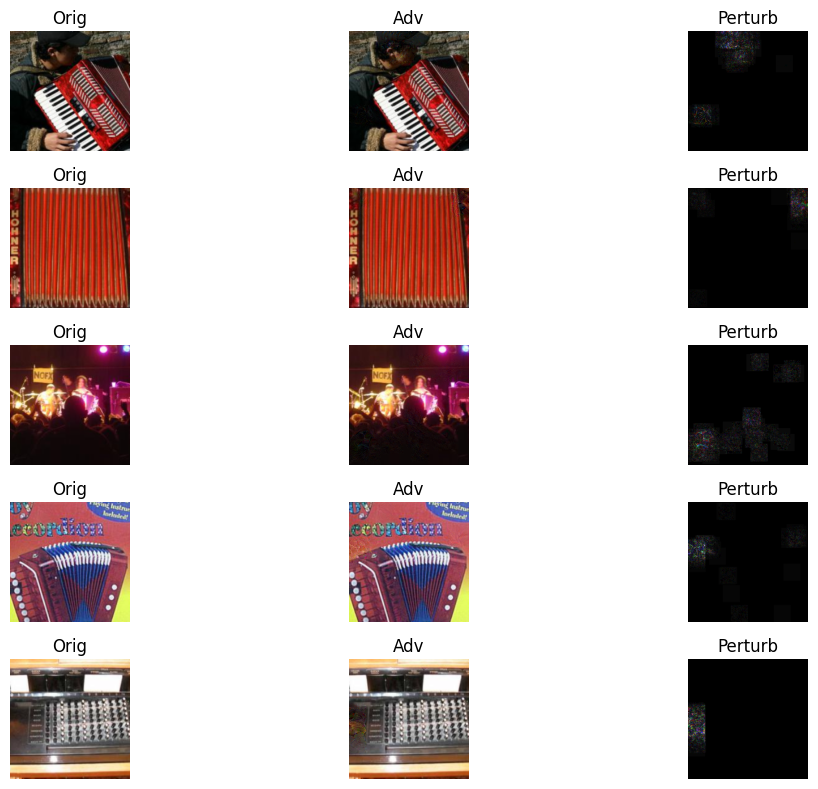

In [36]:
# VISUALIZE FAILURES
plt.figure(figsize=(12,8))
for i,(o,a,d) in enumerate(patch_examples):
    plt.subplot(5,3,i*3+1); plt.imshow(o); plt.title("Orig"); plt.axis('off')
    plt.subplot(5,3,i*3+2); plt.imshow(a); plt.title("Adv");  plt.axis('off')
    plt.subplot(5,3,i*3+3); plt.imshow(d); plt.title("Perturb"); plt.axis('off')
plt.tight_layout(); plt.show()

In [37]:
metrics = {
    "task4": {
        "epsilon_patch": float(epsilon_patch),
        "patch_size": patch_size,
        "steps": steps,
        "restarts": restarts,
        "adv_top1": adv_top1,
        "adv_top5": adv_top5,
        "drop_top1": drop1,
        "drop_top5": drop5
    }
}
with open(os.path.join(output_dir3, "task4_results.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Task 5

## Part 1: Densenet-121

In [38]:
import os
import json
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
original_dir = "/kaggle/input/test-dataset/TestDataSet"
adv_dirs = {
    "Adv Set 1 (FGSM)": "/kaggle/working/Adversarial_Test_Set_1",
    "Adv Set 2 (PGD)": "/kaggle/working/Adversarial_Test_Set_2",
    "Adv Set 3 (RR-Targeted Patch PGD)": "/kaggle/working/Adversarial_Test_Set_3",
}

In [41]:
with open(os.path.join(original_dir, "labels_list.json"), "r") as f:
    raw = json.load(f)
label_ids = [int(entry.split(":",1)[0]) for entry in raw]


In [42]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [43]:
def get_loader(path):
    ds = datasets.ImageFolder(path, transform=transform)
    mapping = {wnid: label_ids[i] for i, wnid in enumerate(ds.classes)}
    ds.class_to_idx = mapping
    ds.samples = [(p, mapping[os.path.basename(os.path.dirname(p))]) for p,_ in ds.samples]
    ds.targets = [t for _,t in ds.samples]
    return DataLoader(ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

loaders = {"Original": get_loader(original_dir)}
for name, path in adv_dirs.items():
    loaders[name] = get_loader(path)


In [44]:
densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
densenet = densenet.to(device).eval()


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 184MB/s]


In [45]:
def eval_model(model, loader):
    top1 = top5 = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            _, preds = logits.topk(5, dim=1)
            hits = preds.eq(labels.view(-1,1))
            top1 += hits[:, :1].sum().item()
            top5 += hits.any(dim=1).sum().item()
            total += labels.size(0)
    return top1/total*100, top5/total*100

### Adversarial Attack Transferability Results: DenseNet-121

*   **Original → Top-1: 70.80%   Top-5: 91.20%**
    *   Baseline performance of DenseNet-121 on the clean, unperturbed dataset.
    *   Serves as the reference point to measure the impact of adversarial attacks.

*   **Adv Set 1 (FGSM) → Top-1: 43.20%   Top-5: 70.00%**
    *   DenseNet-121's accuracy on images perturbed by the Fast Gradient Sign Method (FGSM).
    *   A significant drop in Top-1 accuracy (from 70.80% to 43.20%) indicates that these FGSM attacks transfer effectively and can fool DenseNet-121.

*   **Adv Set 2 (PGD) → Top-1: 59.60%   Top-5: 83.80%**
    *   DenseNet-121's accuracy on images perturbed by Projected Gradient Descent (PGD).
    *   The accuracy degradation is less severe than with FGSM (Top-1 drops to 59.60%).
    *   This suggests PGD attacks, while generally stronger, might be more tailored to the source model they were generated against, thus showing slightly less transferability in this instance, or DenseNet-121 is coincidentally more robust to these specific PGD perturbations.

*   **Adv Set 3 (RR-Targeted Patch PGD) → Top-1: 63.00%   Top-5: 85.80%**
    *   DenseNet-121's accuracy on images perturbed by a targeted Patch PGD attack with Random Restarts (modifying only a small image patch).
    *   This attack method causes the smallest drop in accuracy (Top-1 to 63.00%) among the adversarial sets.
    *   The localized nature of patch attacks might make them highly effective against the source model but less generalizable (less transferable) to a different model like DenseNet-121.

**Key Takeaway:**
*   Adversarial attacks demonstrate transferability to DenseNet-121, but the extent varies by attack type.
*   Simpler FGSM attacks showed high transferability here.
*   More complex PGD and highly localized Patch PGD attacks, while still impactful, were less effective when transferred to DenseNet-121 in this experiment.

In [46]:
print("=== DenseNet-121 Transferability ===")
for ds_name, loader in loaders.items():
    t1, t5 = eval_model(densenet, loader)
    print(f"{ds_name:25} -> Top-1: {t1:5.2f}%   Top-5: {t5:5.2f}%")

=== DenseNet-121 Transferability ===
Original                  -> Top-1: 70.80%   Top-5: 91.20%
Adv Set 1 (FGSM)          -> Top-1: 43.20%   Top-5: 70.00%
Adv Set 2 (PGD)           -> Top-1: 59.60%   Top-5: 83.80%
Adv Set 3 (RR-Targeted Patch PGD) -> Top-1: 63.00%   Top-5: 85.80%


## Part 2: ViT-B_16

In [47]:
import os
import json
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
original_dir = "/kaggle/input/test-dataset/TestDataSet"
adv_dirs = {
    "Adv Set 1 (FGSM)": "/kaggle/working/Adversarial_Test_Set_1",
    "Adv Set 2 (PGD)": "/kaggle/working/Adversarial_Test_Set_2",
    "Adv Set 3 (RR-Targeted Patch PGD)": "/kaggle/working/Adversarial_Test_Set_3",
}

In [50]:
with open(os.path.join(original_dir, "labels_list.json"), "r") as f:
    raw = json.load(f)
label_ids = [int(entry.split(":",1)[0]) for entry in raw]

In [51]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

In [52]:
def get_loader(path):
    ds = datasets.ImageFolder(path, transform=transform)
    mapping = {wnid: label_ids[i] for i, wnid in enumerate(ds.classes)}
    ds.class_to_idx = mapping
    ds.samples = [
        (p, mapping[os.path.basename(os.path.dirname(p))])
        for p,_ in ds.samples
    ]
    ds.targets = [t for _,t in ds.samples]
    return DataLoader(ds, batch_size=32, shuffle=False,
                      num_workers=4, pin_memory=True)
# build all loaders
loaders = {"Original": get_loader(original_dir)}
for name, path in adv_dirs.items():
    loaders[name] = get_loader(path)

In [53]:
# load ViT-B_16
vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
vit = vit.to(device).eval()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 210MB/s] 


In [54]:
def eval_model(model, loader):
    top1 = top5 = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            _, preds5 = logits.topk(5, dim=1)
            hits = preds5.eq(labels.view(-1,1))
            top1 += hits[:, :1].sum().item()
            top5 += hits.any(dim=1).sum().item()
            total += labels.size(0)
    return top1/total*100, top5/total*100

### Adversarial Attack Transferability Results: ViT-B_16

*   **Original → Top-1: 90.00%   Top-5: 99.00%**
    *   This is the baseline performance of the ViT-B_16 model on the original, unperturbed (clean) dataset.
    *   The high initial accuracy (90% Top-1) indicates a strong base model.

*   **Adv Set 1 (FGSM) → Top-1: 73.60%   Top-5: 94.80%**
    *   ViT-B_16's accuracy when evaluated on adversarial examples generated using the Fast Gradient Sign Method (FGSM).
    *   There's a notable drop in Top-1 accuracy (from 90.00% to 73.60%). This demonstrates that FGSM attacks possess a considerable degree of transferability to the ViT-B_16 architecture.

*   **Adv Set 2 (PGD) → Top-1: 82.20%   Top-5: 97.40%**
    *   ViT-B_16's accuracy on adversarial examples crafted using Projected Gradient Descent (PGD).
    *   The accuracy drop is less pronounced (Top-1 to 82.20%) compared to FGSM.
    *   Similar to observations with other architectures, this might indicate that PGD attacks, while often more potent against their original target, could be more overfitted to the source model, leading to slightly reduced transferability to ViT-B_16 in this scenario.

*   **Adv Set 3 (RR-Targeted Patch PGD) → Top-1: 82.80%   Top-5: 97.00%**
    *   ViT-B_16's accuracy on adversarial examples generated using a targeted Patch PGD attack with Random Restarts.
    *   This attack causes the smallest reduction in performance (Top-1 to 82.80%) among the tested adversarial sets.
    *   The highly localized nature of patch attacks, focused on small image regions, appears to be less effective when transferred to the ViT-B_16 model compared to global perturbations, suggesting these attacks might be very specific to the feature extraction mechanisms of the source model.

**Key Takeaway:**
*   The ViT-B_16 model, despite its different architecture (Transformer-based vs. CNN-based like DenseNet), is still susceptible to transferred adversarial attacks.
*   FGSM attacks showed the most significant impact in terms of transferability in this experiment.
*   More sophisticated PGD and highly localized Patch PGD attacks, while still reducing accuracy, were less effective when transferred to ViT-B_16, implying that the ViT architecture might be relatively more resilient to these specific types of transferred attacks or that the attacks were more source-model-specific.
*   Overall, ViT-B_16 maintains a higher accuracy on these transferred adversarial sets compared to the DenseNet-121 example, which might suggest some inherent robustness or different vulnerability characteristics.

In [55]:
print("=== ViT-B_16 Transferability ===")
for ds_name, loader in loaders.items():
    t1, t5 = eval_model(vit, loader)
    print(f"{ds_name:25} -> Top-1: {t1:5.2f}%   Top-5: {t5:5.2f}%")

=== ViT-B_16 Transferability ===
Original                  -> Top-1: 90.00%   Top-5: 99.00%
Adv Set 1 (FGSM)          -> Top-1: 73.60%   Top-5: 94.80%
Adv Set 2 (PGD)           -> Top-1: 82.20%   Top-5: 97.40%
Adv Set 3 (RR-Targeted Patch PGD) -> Top-1: 82.80%   Top-5: 97.20%


## Plots 

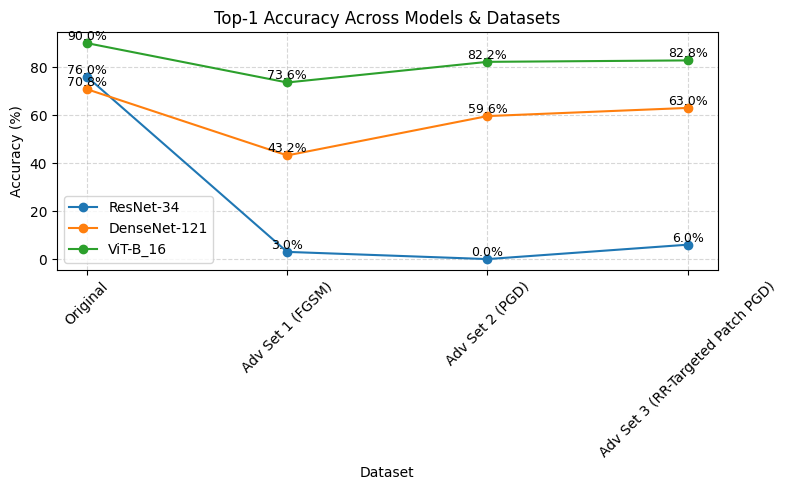

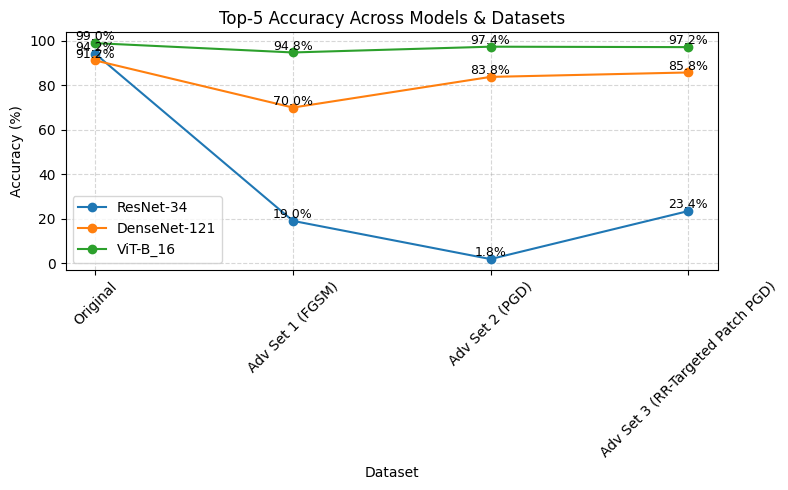

In [58]:
import os, json, torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

original_dir = "/kaggle/input/test-dataset/TestDataSet"
adv_dirs = {
    "Adv Set 1 (FGSM)":      "/kaggle/working/Adversarial_Test_Set_1",
    "Adv Set 2 (PGD)":       "/kaggle/working/Adversarial_Test_Set_2",
    "Adv Set 3 (RR-Targeted Patch PGD)": "/kaggle/working/Adversarial_Test_Set_3",
}


with open(os.path.join(original_dir, "labels_list.json")) as f:
    raw = json.load(f)
label_ids = [int(x.split(":",1)[0]) for x in raw]

tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

def make_loader(path):
    ds = datasets.ImageFolder(path, transform=tf)
    mapping = {wnid: label_ids[i] for i, wnid in enumerate(ds.classes)}
    ds.class_to_idx = mapping
    ds.samples = [(p, mapping[os.path.basename(os.path.dirname(p))]) for p,_ in ds.samples]
    ds.targets = [t for _,t in ds.samples]
    return DataLoader(ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

loaders = {"Original": make_loader(original_dir)}
for k, p in adv_dirs.items():
    loaders[k] = make_loader(p)

models_to_eval = {
    "DenseNet-121": models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to(device).eval(),
    "ViT-B_16":     models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device).eval(),
}

@torch.no_grad()
def eval_model(model, loader):
    top1 = top5 = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, p5 = logits.topk(5, dim=1)
        hits = p5.eq(y.view(-1,1))
        top1 += hits[:, :1].sum().item()
        top5 += hits.any(dim=1).sum().item()
        tot  += y.size(0)
    return top1/tot*100, top5/tot*100

results = {m: {} for m in models_to_eval}

for m_name, m in models_to_eval.items():
    for ds_name, loader in loaders.items():
        results[m_name][ds_name] = eval_model(m, loader)


# inject the *final* ResNet-34 numbers from your table

results["ResNet-34"] = {
    "Original":                            (76.0, 94.2),
    "Adv Set 1 (FGSM)":                    ( 3.0, 19.0),
    "Adv Set 2 (PGD)":                     ( 0.0,  1.8),
    "Adv Set 3 (RR-Targeted Patch PGD)":   ( 6.0, 23.4),
}


datasets = list(loaders.keys())

def plot_metric(idx, title):
    plt.figure(figsize=(8,5))
    for model_name in ["ResNet-34", "DenseNet-121", "ViT-B_16"]:
        vals = [results[model_name][d][idx] for d in datasets]
        plt.plot(datasets, vals, marker='o', label=model_name)
        for i, v in enumerate(vals):
            plt.text(i, v + 1.3, f"{v:.1f}%", ha='center', fontsize=9)
    plt.title(title)
    plt.xlabel("Dataset")
    plt.ylabel("Accuracy (%)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metric(0, "Top-1 Accuracy Across Models & Datasets")
plot_metric(1, "Top-5 Accuracy Across Models & Datasets")


### ResNet-34 Transferability

| Dataset                             | Top-1   | Top-5   |
|-------------------------------------|---------|---------|
| Original                            | 76.00%  | 94.20%  |
| Adv Set 1 (FGSM)                    |  3.00%  | 19.00%  |
| Adv Set 2 (PGD)                     |  0.00%  |  1.80%  |
| Adv Set 3 (RR-Targeted Patch PGD)   |  6.00%  | 23.40%  |

---

### DenseNet-121 Transferability

| Dataset                              | Top-1   | Top-5   |
|--------------------------------------|---------|---------|
| Original                             | 70.80%  | 91.20%  |
| Adv Set 1 (FGSM)                     | 43.20%  | 70.00%  |
| Adv Set 2 (PGD)                      | 59.60%  | 83.80%  |
| Adv Set 3 (RR-Targeted Patch PGD)    | 63.00%  | 85.80%  |

---

### ViT-B_16 Transferability

| Dataset                              | Top-1   | Top-5   |
|--------------------------------------|---------|---------|
| Original                             | 90.00%  | 99.00%  |
| Adv Set 1 (FGSM)                     | 73.60%  | 94.80%  |
| Adv Set 2 (PGD)                      | 82.20%  | 97.40%  |
| Adv Set 3 (RR-Targeted Patch PGD)    | 82.80%  | 97.20%  |

---

### Observations & Trends

- **CNN->CNN transfer**  
  FGSM attacks crafted on ResNet-34 lead to substantial vulnerability in DenseNet-121, with Top-1 dropping by ~27 pp and Top-5 by ~21 pp.  
  This indicates that convolutional architectures with similar feature hierarchies share exploitable patterns, making single-step attacks highly transferable.

- **CNN->ViT transfer**  
  Vision Transformers (ViT) show greater resilience: FGSM causes only ~16 pp Top-1 and ~4 pp Top-5 drops.  
  The global self-attention mechanism and patch embeddings in ViT likely disrupt the local convolutional cues that FGSM attacks target, reducing transferability.

- **Pixel-based vs. patch-based attacks**  
  Full-image PGD (Adv Set 2) yields moderate drops (~10–11 pp) across both DenseNet and ViT, while patch-based PGD (Adv Set 3) causes even smaller declines.  
  Restricting perturbations to a small region significantly limits transfer effectiveness, especially on models like ViT that can attend globally.

- **Architecture matters**  
  DenseNet’s skip-connections and feature reuse result in stronger alignment with ResNet vulnerabilities, whereas ViT’s transformer blocks emphasize different representations.  
  This architectural diversity suggests that ensembles combining CNNs and Transformers can naturally mitigate shared adversarial weaknesses.

---

### Lessons & Mitigations

- **Architectural diversity**  
  Building ensembles of heterogeneous models (e.g. ResNets, DenseNets, ViTs) reduces the chance that a single adversarial example fools all members.  
  Attacks tailored to one architecture often fail or degrade in potency on others, providing a practical defense through diversity.

- **Adversarial training**  
  Incorporating a variety of adversarial examples (FGSM, PGD, patch-based) from multiple backbones into the training loop enhances model robustness.  
  By exposing the network to diverse perturbation styles, it learns to generalize defenses beyond any single attack method.

- **Pre-/post-processing defenses**  
  Simple input transformations, random resizing, JPEG compression, bit-depth quantization, can effectively neutralize small-ε or localized noise.  
  These operations introduce stochasticity that breaks the precise perturbation patterns adversarial algorithms rely on.

- **Detection strategies**  
  Monitoring per-patch gradient magnitudes or analyzing attention consistency in transformers can flag suspicious inputs.  
  Adversarial examples often produce abnormal gradient “hotspots” or inconsistent attention maps, offering signals for rejection or further sanitization.  

  
